In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from scipy.linalg import svd, subspace_angles, orth

import gseapy as gp
import scanpy as sc
#import pydeseq2 as pyd2
#from pydeseq2.dds import DeseqDataSet



In [311]:
control_group = pd.read_excel('_a7ebd2b56abe41d344c62ff51f62afa6_Transciptomic-Data--Control-Group.xlsx')
control_group.head()

,Gene Name,MDAMB453 Cell Line,MDAMB231 Cell Line,MDAMB468 Cell Line,BT549 Cell Line,CAL851 Cell Line
0,1/2-SBSRNA4,3.999746,6.281882,4.706822,4.241822,5.193640
1,A1BG,7.717929,5.286117,4.167404,5.348666,5.304134
2,A1BG-AS1,5.844432,4.591649,4.500660,3.644126,5.666137
3,A1CF,5.572347,5.154188,4.330445,3.709960,5.890612
4,A2LD1,6.025314,4.483234,6.581222,6.828709,8.031257


In [312]:
drug_group = pd.read_excel('_a81fad69520a7b5be0fb70d9c6fbf6a7_Transciptomic-Data--Drug-Group.xlsx')
drug_group.head()

,Gene Name,MDAMB453 Cell Line,MDAMB231 Cell Line,MDAMB468 Cell Line,BT549 Cell Line,CAL851 Cell Line
0,1/2-SBSRNA4,4.000746,6.251882,4.720942,4.220613,5.201640
1,A1BG,7.725929,5.256117,4.179906,5.321923,5.312134
2,A1BG-AS1,5.852432,4.561649,4.514162,3.625905,5.674137
3,A1CF,5.580347,5.124188,4.343436,3.691410,5.898612
4,A2LD1,6.033314,4.453234,6.600966,6.794565,8.039257


## Data Preprocessing

In [413]:
def normalise_data(df):
    # compute min max normalisation for each cell line
    df = df.set_index('Gene Name')
    normalized_df = (df - df.min()) / (df.max() - df.min())
    #normalized_df = (df - df.mean()) / df.std()
    
    return normalized_df.reset_index()

def log_transform_data(df):
    
    df = df.set_index('Gene Name')
    log_df = np.log2(df + 1)

    return log_df.reset_index()


def preprocess_data(df):
    
    df = normalise_data(df)
    df = log_transform_data(df)
    df = df.set_index('Gene Name')     
    # Remove lowly expressed genes (genes with expression values below the 25th percentile)
    #df = df[df.apply(lambda x: x > x.quantile(0.25)).all(axis=1)]

    # Remove genes with zero variance
    df = df.loc[df.var(axis=1) != 0]
    return df.reset_index()



def differential_expression(control_df, drug_df):
    de_results = []
    control_df.set_index('Gene Name',inplace = True)
    drug_df.set_index('Gene Name',inplace = True)
    fold_change_df  = compute_fold_change(control_df.reset_index(), drug_df.reset_index())
    for gene in control_df.index:
        # Get expression values for this gene in all cell lines
        control_group = control_df.loc[gene]
        drug_group = drug_df.loc[gene]

        # Perform t-test
        t_stat, p_value = ttest_ind(control_group, drug_group,equal_var=False, nan_policy='omit')

        # Calculate fold change
        fold_change = fold_change_df.loc[gene].mean()

        # Create a DataFrame with results
        results = pd.DataFrame({
            'Gene': gene,
            't_stat': t_stat,
            'p_value': p_value,
            'fold_change': fold_change
        }, index=[0])

        de_results.append(results)

    # Combine all results into a single DataFrame
    de_results = pd.concat(de_results)

    # Adjust p-values using Benjamini-Hochberg procedure (the qvalues), accounting for multiple testing
    de_results['adjusted_p_value'] = multipletests(de_results['p_value'], method='fdr_bh')[1]

    return de_results


def compute_fold_change(control_df, drug_df):

    control_df.set_index('Gene Name',inplace = True)
    drug_df.set_index('Gene Name',inplace = True)

    fold_change_df = pd.DataFrame(index=control_df.index)

    cell_lines = ['MDAMB453', 'MDAMB231', 'MDAMB468', 'BT549', 'CAL851']

    for cell_line in cell_lines:
        control_col = f'{cell_line} Cell Line'
        drug_col = f'{cell_line} Cell Line'
        
        # Calculate fold change (drug/control) for each gene
        fold_change = drug_df[drug_col] / control_df[control_col] -1 
        
        # Add fold change values to the dataframe
        fold_change_df[cell_line + ' Fold Change'] = fold_change

    # Replace infinities or -infinities with NaN
    fold_change_df.replace([np.inf, -np.inf], 1, inplace=True)

    return fold_change_df

In [414]:
# Preprocess the data
preprocessed_control_data = preprocess_data(control_group)
preprocessed_drug_data = preprocess_data(drug_group)

In [415]:
df_fold_change = compute_fold_change(preprocessed_control_data.reset_index(), preprocessed_drug_data.reset_index())
df_fold_change.head()

,MDAMB453 Fold Change,MDAMB231 Fold Change,MDAMB468 Fold Change,BT549 Fold Change,CAL851 Fold Change
Gene Name,,,,,
1/2-SBSRNA4,0.546585,0.249695,0.548838,0.249670,0.309535
A1BG,0.107241,0.380303,0.795293,0.146058,0.293838
A1BG-AS1,0.211833,0.549752,0.625694,0.361263,0.249967
A1CF,0.237405,0.405362,0.703724,0.345340,0.227421
A2LD1,0.196954,0.587528,0.225855,0.081697,0.104776


In [416]:
# Perform differential expression analysis
cell_lines = ['MDAMB453', 'MDAMB231', 'MDAMB468', 'BT549', 'CAL851']
de_results = differential_expression(preprocessed_control_data.reset_index(), preprocessed_drug_data.reset_index())
de_results

,Gene,t_stat,p_value,fold_change,adjusted_p_value
0,1/2-SBSRNA4,-0.983505,0.349811,0.380865,0.999999
0,A1BG,-0.411370,0.689643,0.344547,0.999999
0,A1BG-AS1,-0.181908,0.859299,0.399702,0.999999
0,A1CF,-0.114241,0.911310,0.383850,0.999999
0,A2LD1,-0.069199,0.946196,0.239362,0.999999
...,...,...,...,...,...
0,ZYG11A,-0.000010,0.999992,0.120987,0.999999
0,ZYG11B,-0.000008,0.999994,0.073250,0.999999
0,ZYX,-0.000009,0.999993,0.108827,0.999999
0,ZZEF1,-0.000015,0.999989,0.331403,0.999999


In [417]:
de_results['adjusted_p_value'].unique()

array([0.99999894])

In [318]:
de_results['p_value'].min()

0.34981064169551335

In [319]:
print(de_results['fold_change'].max())
de_results['fold_change'].min()


15.5381230207413


-0.9306595945051042

In [418]:
# Calculate log2 fold change and -log10 adjusted p-value
de_results['log2fc'] = np.log2(de_results['fold_change'])
de_results['-log10p'] = -np.log10(de_results['p_value'])

# Define significance thresholds
threshold_log2fc = np.log2(2)  # Equivalent to a fold change of 2
threshold_log10p = -np.log10(0.6)  # Equivalent to an adjusted p-value of 0.05

# Create a volcano plot
fig = go.Figure()

# Add all points
fig.add_trace(go.Scatter(
    x=de_results['log2fc'],
    y=de_results['-log10p'],
    mode='markers',
    text=de_results.index,  # Display gene names on hover
    marker=dict(
        color='gray',  # Color points gray by default
        line=dict(width=1)  # Outline markers
    ),
    hovertemplate="<b>%{text}</b><br><br>log2fc: %{x}<br>-log10p: %{y}<extra></extra>",  # Customize hover text
    name=''
))

# Highlight significant points
fig.add_trace(go.Scatter(
    x=de_results.loc[(de_results['log2fc'].abs() > threshold_log2fc) & (de_results['-log10p'] > threshold_log10p), 'log2fc'],
    y=de_results.loc[(de_results['log2fc'].abs() > threshold_log2fc) & (de_results['-log10p'] > threshold_log10p), '-log10p'],
    mode='markers',
    text=de_results.loc[(de_results['log2fc'].abs() > threshold_log2fc) & (de_results['-log10p'] > threshold_log10p)].index,
    marker=dict(
        color='red',  # Color significant points red
        line=dict(width=1)
    ),
    hovertemplate="<b>%{text}</b><br><br>log2fc: %{x}<br>-log10p: %{y}<extra></extra>",
    name='Significant'
))

# Add lines to denote significance thresholds
fig.add_shape(type="line", x0=threshold_log2fc, x1=threshold_log2fc, y0=0, y1=de_results['-log10p'].max(), line=dict(color="black", width=1))
fig.add_shape(type="line", x0=-threshold_log2fc, x1=-threshold_log2fc, y0=0, y1=de_results['-log10p'].max(), line=dict(color="black", width=1))
fig.add_shape(type="line", x0=de_results['log2fc'].min(), x1=de_results['log2fc'].max(), y0=threshold_log10p, y1=threshold_log10p, line=dict(color="black", width=1))

# Update layout
fig.update_layout(
    title='Volcano plot',
    xaxis_title='log2 fold change',
    yaxis_title='-log10 adjusted p-value',
    showlegend=True,
    autosize=False,
    width=800,
    height=600,
)

# Show plot
fig.show()

/opt/miniconda3/envs/omic_analysis/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log2



/opt/miniconda3/envs/omic_analysis/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

invalid value encountered in log2



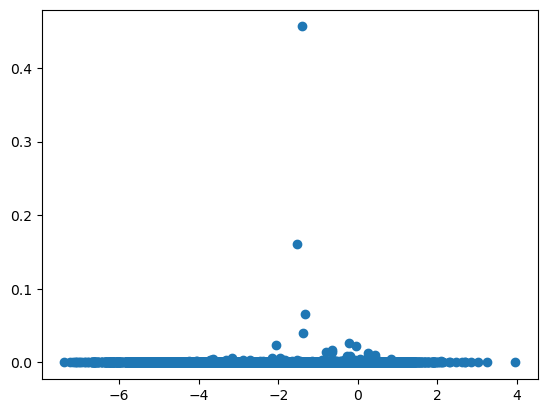

In [419]:
plt.scatter(np.log2(de_results['fold_change']), -np.log10(de_results['p_value']))


In [420]:
# Filter for significantly differentially expressed genes (DEGs)
degs = de_results[(de_results['fold_change'] < 2) & (de_results['p_value'] < 0.1)]
degs

,Gene,t_stat,p_value,fold_change,adjusted_p_value,log2fc,-log10p


In [421]:
# Identify consistent gene expression changes across cell lines
consistently_degs = degs.groupby('Gene').filter(lambda x: len(x) == len(cell_lines))

print(consistently_degs)

Empty DataFrame
Columns: [Gene, t_stat, p_value, fold_change, adjusted_p_value, log2fc, -log10p]
Index: []


### Fold change approach

since the mean fold change for specific genes does not seem to have statistically significant changes accross all the cell types, 
we analyse cell types one by one. 

In [422]:
df_fold_change = compute_fold_change(preprocessed_control_data.reset_index(), preprocessed_drug_data.reset_index())
df_fold_change.head()

,MDAMB453 Fold Change,MDAMB231 Fold Change,MDAMB468 Fold Change,BT549 Fold Change,CAL851 Fold Change
Gene Name,,,,,
1/2-SBSRNA4,0.546585,0.249695,0.548838,0.249670,0.309535
A1BG,0.107241,0.380303,0.795293,0.146058,0.293838
A1BG-AS1,0.211833,0.549752,0.625694,0.361263,0.249967
A1CF,0.237405,0.405362,0.703724,0.345340,0.227421
A2LD1,0.196954,0.587528,0.225855,0.081697,0.104776


In [423]:
#finding gene signature: genes that are differentially expressed in all cell lines
# Get the genes that are differentially expressed in all cell lines
common_genes = df_fold_change.index[df_fold_change.apply(lambda x: x.abs() > 1.2).all(axis=1)]

# Print the results
print(f"Number of genes that are differentially expressed in all cell lines: {len(common_genes)}")
common_genes


Number of genes that are differentially expressed in all cell lines: 0


Index([], dtype='object', name='Gene Name')

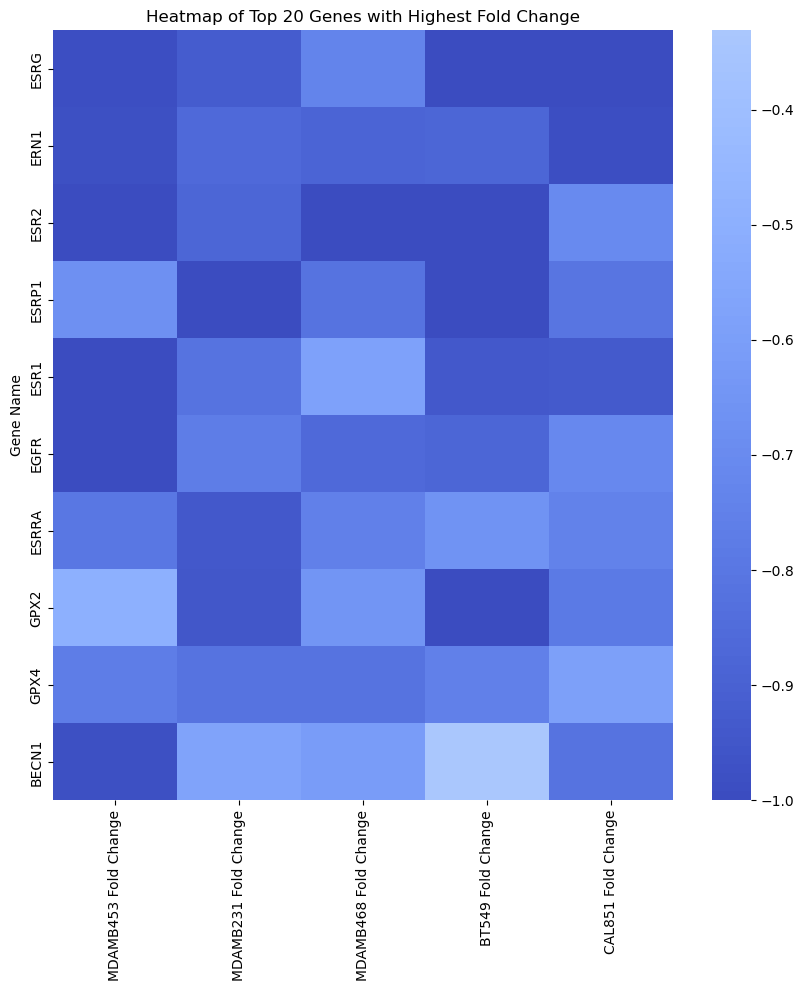

In [428]:
# Compute the average fold change for each gene
avg_fold_change = df_fold_change.mean(axis=1)

# Get the top 20 genes with the highest and lowest fold change
top_positive_genes = avg_fold_change.nlargest(20).index
top_negative_genes = avg_fold_change.nsmallest(20).index

# Compute the average fold change for each gene
avg_fold_change = df_fold_change.mean(axis=1)

# Get the top 20 genes with the highest and lowest fold change
top_positive_genes = avg_fold_change.nlargest(20).index
top_negative_genes = avg_fold_change.nsmallest(10).index

selected_genes = np.concatenate([top_negative_genes])
df_selected = df_fold_change.loc[selected_genes]


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(df_selected, cmap='coolwarm', center=0)
plt.title('Heatmap of Top 20 Genes with Lowest Fold Change')
plt.show()


In [326]:
gene_list = []

In [327]:
# find the top 10 differentially expressed genes in df_fold_change
# Flatten the DataFrame and sort by value
flat_df = df_fold_change.unstack().sort_values(ascending=False)

# Get the top 10 values
top_10 = flat_df.head(50)
gene_list = gene_list + top_10.reset_index()['Gene Name'].tolist()
# Print the results
for idx, value in top_10.iteritems():
    print(f"Row: {idx[1]}, Column: {idx[0]}, Value: {value}")

Row: GLRA3, Column: CAL851 Fold Change, Value: 71.42133678362342
Row: CNGA3, Column: CAL851 Fold Change, Value: 36.25783366927692
Row: LUM, Column: MDAMB468 Fold Change, Value: 28.625783973438455
Row: LOC400590, Column: MDAMB468 Fold Change, Value: 26.01372003648999
Row: DNHD1, Column: MDAMB231 Fold Change, Value: 22.375651711311406
Row: OR5H1, Column: MDAMB468 Fold Change, Value: 21.697274519379853
Row: SH3GL2, Column: MDAMB468 Fold Change, Value: 21.423671951837445
Row: DNHD1, Column: MDAMB468 Fold Change, Value: 18.940907485639695
Row: LOC642426, Column: MDAMB231 Fold Change, Value: 18.824723137369485
Row: GRIK2, Column: MDAMB231 Fold Change, Value: 18.4139144529318
Row: USH2A, Column: CAL851 Fold Change, Value: 16.719086411444398
Row: C1orf114, Column: MDAMB231 Fold Change, Value: 15.90012316580226
Row: C11orf58, Column: MDAMB231 Fold Change, Value: 15.593705635664517
Row: HSD17B4, Column: MDAMB468 Fold Change, Value: 15.337957404356168
Row: MGC42157, Column: MDAMB231 Fold Change, 

In [328]:
# find the top 10 differentially expressed genes in df_fold_change
# Flatten the DataFrame and sort by value
flat_df = df_fold_change.unstack().sort_values(ascending=True)

# Get the top 10 values
top_10 = flat_df.head(50)
gene_list = gene_list + top_10.reset_index()['Gene Name'].tolist()
# Print the results
for idx, value in top_10.iteritems():
    print(f"Row: {idx[1]}, Column: {idx[0]}, Value: {value}")

Row: ESRG, Column: CAL851 Fold Change, Value: -1.0
Row: ESR2, Column: MDAMB468 Fold Change, Value: -1.0
Row: ESR2, Column: MDAMB453 Fold Change, Value: -1.0
Row: ESR2, Column: BT549 Fold Change, Value: -1.0
Row: ESRP1, Column: MDAMB231 Fold Change, Value: -1.0
Row: GPX2, Column: BT549 Fold Change, Value: -0.9995825288166107
Row: EGFR, Column: MDAMB453 Fold Change, Value: -0.9994732734538656
Row: ESR1, Column: MDAMB453 Fold Change, Value: -0.9986104562154816
Row: ESRG, Column: BT549 Fold Change, Value: -0.998065612624769
Row: ESRP1, Column: BT549 Fold Change, Value: -0.9975576309003532
Row: ERN1, Column: CAL851 Fold Change, Value: -0.9919369676758308
Row: ESRG, Column: MDAMB453 Fold Change, Value: -0.9905825403624181
Row: BECN1, Column: MDAMB453 Fold Change, Value: -0.9838076997029613
Row: ERN1, Column: MDAMB453 Fold Change, Value: -0.9815619506822383
Row: GPX2, Column: MDAMB231 Fold Change, Value: -0.9455431407162773
Row: ESRRA, Column: MDAMB231 Fold Change, Value: -0.9424367163345891


## Gene Set enrichment analysis

In [329]:
df_sets = pd.read_json('c5.all.v2023.1.Hs.json')
df_sets.head()

,GOBP_10_FORMYLTETRAHYDROFOLATE_METABOLIC_PROCESS,GOBP_2_OXOGLUTARATE_METABOLIC_PROCESS,GOBP_2FE_2S_CLUSTER_ASSEMBLY,GOBP_3_PHOSPHOADENOSINE_5_PHOSPHOSULFATE_METABOLIC_PROCESS,GOBP_3_UTR_MEDIATED_MRNA_DESTABILIZATION,GOBP_3_UTR_MEDIATED_MRNA_STABILIZATION,GOBP_4FE_4S_CLUSTER_ASSEMBLY,GOBP_5_PHOSPHORIBOSE_1_DIPHOSPHATE_METABOLIC_PROCESS,GOBP_5S_CLASS_RRNA_TRANSCRIPTION_BY_RNA_POLYMERASE_III,GOBP_7_METHYLGUANOSINE_CAP_HYPERMETHYLATION,...,HP_XANTHOMATOSIS,HP_XEROSTOMIA,HP_Y_LINKED_INHERITANCE,HP_Y_SHAPED_METACARPALS,HP_YELLOW_BROWN_DISCOLORATION_OF_THE_TEETH,HP_YELLOW_WHITE_LESIONS_OF_THE_MACULA,HP_YELLOW_WHITE_LESIONS_OF_THE_RETINA,HP_YOUNG_ADULT_ONSET,HP_ZOLLINGER_ELLISON_SYNDROME,HP_ZONULAR_CATARACT
systematicName,M29088,M15857,M23654,M23897,M24263,M11060,M45874,M29212,M29174,M45135,...,M35062,M34609,M35297,M36796,M36819,M38383,M38385,M37856,M35606,M37696
pmid,,,,,,,,,,,...,,,,,,,,,,
exactSource,GO:0009256,GO:0006103,GO:0044571,GO:0050427,GO:0061158,GO:0070935,GO:0044572,GO:0046391,GO:0042791,GO:0036261,...,HP:0000991,HP:0000217,HP:0001450,HP:0006042,HP:0006286,HP:0030500,HP:0030506,HP:0011462,HP:0002044,HP:0010920
geneSymbols,"[AASDHPPT, ALDH1L1, ALDH1L2, MTHFD1, MTHFD1L, ...","[AADAT, ADHFE1, D2HGDH, DLST, GOT1, GOT2, GPT2...","[BOLA2, BOLA2B, FDX2, FXN, GLRX3, GLRX5, HSCB,...","[ABHD14B, BPNT1, ENPP1, PAPSS1, PAPSS2, SULT1A...","[CPEB3, DHX36, DND1, HNRNPD, KHSRP, MOV10, PLE...","[ANGEL2, BOLL, DAZ1, DAZ2, DAZ3, DAZ4, DAZL, E...","[FDX2, FXN, ISCU, LYRM4, NFS1]","[PRPS1, PRPS1L1, PRPS2, PRPSAP1, PRPSAP2, PYGL]","[GTF3C1, GTF3C2, GTF3C3, GTF3C4, GTF3C5, GTF3C6]","[SNRPB, SNRPD1, SNRPD2, SNRPD3, SNRPE, SNRPF, ...",...,"[ABCA1, ABCG5, ABCG8, APOA1, APOA2, APOA5, APO...","[ANG, ANXA11, ATXN2, C9orf72, CAV1, CCN2, CCNF...","[BPY2, CDY1, CDY2A, DAZ1, DAZ2, DAZ3, DDX3Y, H...","[CPLANE1, FAM149B1, GLI3, HOXD13, INTU, KIAA07...","[CNNM4, DLX3, ENAM, FAM20A, ITGB6, KRT14, RELT...","[ABCA4, ALDH3A2, APOE, BEST1, CFH, CFHR1, CFHR...","[ABCA4, ABCC6, AGXT, ALDH3A2, ALMS1, APOE, BES...","[AAAS, AARS1, ABCA4, ABHD12, ACTA1, ACTC1, ACT...","[ATRX, CDKN1A, CDKN1B, CDKN2B, CDKN2C, DAXX, M...","[ACADS, BAP1, BEST1, BFSP1, CFAP410, CHMP4B, C..."
msigdbURL,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,https://www.gsea-msigdb.org/gsea/msigdb/human/...


In [343]:
len(gene_set)

46

In [394]:
def compute_PAEA(gene_set,df_fold_change):
    gene_set = set(gene_set)

    valid_genes = list(gene_set.intersection(df_fold_change.index))
    gene_set_1 = df_fold_change.loc[valid_genes].values
    gene_set_2 = df_fold_change.loc[~df_fold_change.index.isin(valid_genes)].values
    print(gene_set_1.shape)
    print(gene_set_2.shape)
    # Each row is a gene, and each column is a sample

    # Perform SVD to obtain left singular vectors
    U1, _, _ = svd(gene_set_1, full_matrices=False)
    U2, _, _ = svd(gene_set_2, full_matrices=False)

    print(U1.shape)
    print(U2.shape)

    # Calculate the principal angles
    angles = subspace_angles(U1.T, U2.T)

    return angles

def compute_PAEA2(gene_set,df_fold_change):
    gene_set = set(gene_set)

    valid_genes = list(gene_set.intersection(df_fold_change.index))
    gene_set_1 = df_fold_change.loc[valid_genes].values
    gene_set_2 = df_fold_change.loc[~df_fold_change.index.isin(valid_genes)].values
    # Orthogonalize the column space of the two matrices
    U1 = orth(gene_set_1)
    U2 = orth(gene_set_2)
    if gene_set_1.shape[1] > U1.shape[1]:
        print("dimensionality issue")
        return None


    # Compute the singular values of the dot product of the two matrices
    singular_values = svd(np.dot(U1, U2.T), compute_uv=False)

    # Compute the principal angles
    angles = np.arccos(singular_values)


    return angles

In [392]:
gene_set = set(gene_set)
valid_genes = list(gene_set.intersection(df_fold_change.index))

orth(df_fold_change.loc[valid_genes].values)

array([[ 0.23126032,  0.06282712, -0.19520155, -0.95103511],
       [ 0.70616459,  0.67024429, -0.04136597,  0.2244839 ],
       [ 0.21147776, -0.11246034,  0.95879216, -0.15279863],
       [ 0.63492315, -0.73087483, -0.20224441,  0.14762041]])

In [395]:
compute_PAEA2(gene_set,df_fold_change)

(4, 5)
(4, 4)
dimensionality issue


In [397]:
# rank the gene sets according to their significance in gene enrichement analysis
# use characteristic direction method

# Create a DataFrame to store the results
results = pd.DataFrame()

# Iterate over each gene set
geneSetPAEA = []
for col in df_sets.columns:
    temp_dict = {}
    gene_set = df_sets[col]['geneSymbols']
    temp_dict[col] = compute_PAEA2(gene_set,df_fold_change)

(6, 5)
(6, 5)
(16, 5)
(16, 5)
(9, 5)
(9, 5)
(14, 5)
(14, 5)
(15, 5)
(15, 5)
(18, 5)
(18, 5)
(4, 5)
(4, 4)
dimensionality issue
(6, 5)
(6, 5)
(6, 5)
(6, 5)
(8, 5)
(8, 5)
(4, 5)
(4, 4)
dimensionality issue
(5, 5)
(5, 5)
(6, 5)
(6, 5)
(6, 5)
(6, 5)
(17, 5)
(17, 5)
(10, 5)
(10, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(31, 5)
(31, 5)
(4, 5)
(4, 4)
dimensionality issue
(43, 5)
(43, 5)
(60, 5)
(60, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(7, 5)
(7, 5)
(21, 5)
(21, 5)
(34, 5)
(34, 5)
(14, 5)
(14, 5)
(109, 5)
(109, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(123, 5)
(123, 5)
(743, 5)
(743, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(21, 5)
(21, 5)
(153, 5)
(153, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(51, 5)
(51, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(402, 5)
(402, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(144, 5)
(144, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(16, 5)
(16, 5)
(96, 5)
(96, 5)
(4, 5)
(4, 4)
dimensionality issue
(15, 5)
(15, 5)
(45, 5)
(45, 5)
(7, 5)
(7, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(171, 5)
(171, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(132, 5)
(132, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(46, 5)
(46, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(9, 5)
(9, 5)
(23, 5)
(23, 5)
(19, 5)
(19, 5)
(70, 5)
(70, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(98, 5)
(98, 5)
(436, 5)
(436, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(208, 5)
(208, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(15, 5)
(15, 5)
(4, 5)
(4, 4)
dimensionality issue
(17, 5)
(17, 5)
(29, 5)
(29, 5)
(6, 5)
(6, 5)
(104, 5)
(104, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(28, 5)
(28, 5)
(4, 5)
(4, 4)
dimensionality issue
(3, 5)
(3, 3)
dimensionality issue
(7, 5)
(7, 5)
(41, 5)
(41, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(192, 5)
(192, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(106, 5)
(106, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(23, 5)
(23, 5)
(45, 5)
(45, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(36, 5)
(36, 5)
(7, 5)
(7, 5)
(21, 5)
(21, 5)
(447, 5)
(447, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(284, 5)
(284, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(157, 5)
(157, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(16, 5)
(16, 5)
(8, 5)
(8, 5)
(7, 5)
(7, 5)
(25, 5)
(25, 5)
(7, 5)
(7, 5)
(9, 5)
(9, 5)
(110, 5)
(110, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(8, 5)
(8, 5)
(9, 5)
(9, 5)
(77, 5)
(77, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(202, 5)
(202, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(13, 5)
(13, 5)
(6, 5)
(6, 5)
(56, 5)
(56, 5)
(15, 5)
(15, 5)
(11, 5)
(11, 5)
(7, 5)
(7, 5)
(48, 5)
(48, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(88, 5)
(88, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(12, 5)
(12, 5)
(28, 5)
(28, 5)
(30, 5)
(30, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(141, 5)
(141, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(12, 5)
(12, 5)
(80, 5)
(80, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(151, 5)
(151, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(4, 5)
(4, 4)
dimensionality issue
(8, 5)
(8, 5)
(160, 5)
(160, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(17, 5)
(17, 5)
(127, 5)
(127, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(50, 5)
(50, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(336, 5)
(336, 5)
(16, 5)
(16, 5)
(12, 5)
(12, 5)
(5, 5)
(5, 5)
(6, 5)
(6, 5)
(21, 5)
(21, 5)
(11, 5)
(11, 5)
(8, 5)
(8, 5)
(8, 5)
(8, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(84, 5)
(84, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(189, 5)
(189, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(163, 5)
(163, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(114, 5)
(114, 5)
(44, 5)
(44, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(10, 5)
(10, 5)
(71, 5)
(71, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(413, 5)
(413, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(22, 5)
(22, 5)
(747, 5)
(747, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(20, 5)
(20, 5)
(1001, 5)
(1001, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(325, 5)
(325, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(39, 5)
(39, 5)
(16, 5)
(16, 5)
(109, 5)
(109, 5)
(101, 5)
(101, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(24, 5)
(24, 5)
(6, 5)
(6, 5)
(17, 5)
(17, 5)
(13, 5)
(13, 5)
(75, 5)
(75, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(103, 5)
(103, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(51, 5)
(51, 5)
(251, 5)
(251, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(7, 5)
(7, 5)
(95, 5)
(95, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(140, 5)
(140, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(15, 5)
(15, 5)
(40, 5)
(40, 5)
(8, 5)
(8, 5)
(71, 5)
(71, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(32, 5)
(32, 5)
(121, 5)
(121, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(10, 5)
(10, 5)
(7, 5)
(7, 5)
(9, 5)
(9, 5)
(6, 5)
(6, 5)
(23, 5)
(23, 5)
(12, 5)
(12, 5)
(12, 5)
(12, 5)
(5, 5)
(5, 5)
(22, 5)
(22, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(9, 5)
(9, 5)
(5, 5)
(5, 5)
(6, 5)
(6, 5)
(37, 5)
(37, 5)
(8, 5)
(8, 5)
(7, 5)
(7, 5)
(50, 5)
(50, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(36, 5)
(36, 5)
(14, 5)
(14, 5)
(52, 5)
(52, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(68, 5)
(68, 5)
(5, 5)
(5, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(22, 5)
(22, 5)
(16, 5)
(16, 5)
(1084, 5)
(1084, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(221, 5)
(221, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(16, 5)
(16, 5)
(10, 5)
(10, 5)
(5, 5)
(5, 5)
(29, 5)
(29, 5)
(45, 5)
(45, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(27, 5)
(27, 5)
(13, 5)
(13, 5)
(66, 5)
(66, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(30, 5)
(30, 5)
(982, 5)
(982, 5)
(66, 5)
(66, 5)
(34, 5)
(34, 5)
(6, 5)
(6, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(7, 5)
(7, 5)
(49, 5)
(49, 5)
(7, 5)
(7, 5)
(196, 5)
(196, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(45, 5)
(45, 5)
(6, 5)
(6, 5)
(9, 5)
(9, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(49, 5)
(49, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(3, 5)
(3, 3)
dimensionality issue
(9, 5)
(9, 5)
(4, 5)
(4, 4)
dimensionality issue
(5, 5)
(5, 5)
(18, 5)
(18, 5)
(103, 5)
(103, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(28, 5)
(28, 5)
(21, 5)
(21, 5)
(43, 5)
(43, 5)
(34, 5)
(34, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(8, 5)
(8, 5)
(25, 5)
(25, 5)
(7, 5)
(7, 5)
(61, 5)
(61, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(34, 5)
(34, 5)
(15, 5)
(15, 5)
(29, 5)
(29, 5)
(22, 5)
(22, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(176, 5)
(176, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(69, 5)
(69, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(108, 5)
(108, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(23, 5)
(23, 5)
(9, 5)
(9, 5)
(59, 5)
(59, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(33, 5)
(33, 5)
(4, 5)
(4, 4)
dimensionality issue
(38, 5)
(38, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(69, 5)
(69, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(15, 5)
(15, 5)
(5, 5)
(5, 5)
(41, 5)
(41, 5)
(4, 5)
(4, 4)
dimensionality issue
(18, 5)
(18, 5)
(99, 5)
(99, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(1726, 5)
(1726, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(36, 5)
(36, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(26, 5)
(26, 5)
(559, 5)
(559, 5)
(171, 5)
(171, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(138, 5)
(138, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(54, 5)
(54, 5)
(30, 5)
(30, 5)
(21, 5)
(21, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(10, 5)
(10, 5)
(19, 5)
(19, 5)
(15, 5)
(15, 5)
(31, 5)
(31, 5)
(13, 5)
(13, 5)
(35, 5)
(35, 5)
(6, 5)
(6, 5)
(99, 5)
(99, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(70, 5)
(70, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(6, 5)
(6, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(21, 5)
(21, 5)
(15, 5)
(15, 5)
(44, 5)
(44, 5)
(6, 5)
(6, 5)
(20, 5)
(20, 5)
(83, 5)
(83, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(19, 5)
(19, 5)
(8, 5)
(8, 5)
(38, 5)
(38, 5)
(80, 5)
(80, 5)
(17, 5)
(17, 5)
(6, 5)
(6, 5)
(9, 5)
(9, 5)
(66, 5)
(66, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(172, 5)
(172, 5)
(80, 5)
(80, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(15, 5)
(15, 5)
(9, 5)
(9, 5)
(17, 5)
(17, 5)
(22, 5)
(22, 5)
(6, 5)
(6, 5)
(21, 5)
(21, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(13, 5)
(13, 5)
(13, 5)
(13, 5)
(8, 5)
(8, 5)
(27, 5)
(27, 5)
(8, 5)
(8, 5)
(6, 5)
(6, 5)
(19, 5)
(19, 5)
(36, 5)
(36, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(19, 5)
(19, 5)
(15, 5)
(15, 5)
(7, 5)
(7, 5)
(44, 5)
(44, 5)
(8, 5)
(8, 5)
(8, 5)
(8, 5)
(59, 5)
(59, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(105, 5)
(105, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(82, 5)
(82, 5)
(18, 5)
(18, 5)
(9, 5)
(9, 5)
(12, 5)
(12, 5)
(10, 5)
(10, 5)
(9, 5)
(9, 5)
(27, 5)
(27, 5)
(88, 5)
(88, 5)
(9, 5)
(9, 5)
(74, 5)
(74, 5)
(7, 5)
(7, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(454, 5)
(454, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(23, 5)
(23, 5)
(115, 5)
(115, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(21, 5)
(21, 5)
(61, 5)
(61, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(17, 5)
(17, 5)
(5, 5)
(5, 5)
(22, 5)
(22, 5)
(55, 5)
(55, 5)
(9, 5)
(9, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(15, 5)
(15, 5)
(5, 5)
(5, 5)
(257, 5)
(257, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(81, 5)
(81, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(27, 5)
(27, 5)
(8, 5)
(8, 5)
(148, 5)
(148, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(34, 5)
(34, 5)
(6, 5)
(6, 5)
(131, 5)
(131, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(99, 5)
(99, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(65, 5)
(65, 5)
(20, 5)
(20, 5)
(18, 5)
(18, 5)
(41, 5)
(41, 5)
(12, 5)
(12, 5)
(13, 5)
(13, 5)
(9, 5)
(9, 5)
(33, 5)
(33, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(20, 5)
(20, 5)
(612, 5)
(612, 5)
(39, 5)
(39, 5)
(5, 5)
(5, 5)
(14, 5)
(14, 5)
(9, 5)
(9, 5)
(8, 5)
(8, 5)
(19, 5)
(19, 5)
(25, 5)
(25, 5)
(10, 5)
(10, 5)
(28, 5)
(28, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(26, 5)
(26, 5)
(33, 5)
(33, 5)
(44, 5)
(44, 5)
(8, 5)
(8, 5)
(12, 5)
(12, 5)
(36, 5)
(36, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(90, 5)
(90, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(192, 5)
(192, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(106, 5)
(106, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(1461, 5)
(1461, 5)
(53, 5)
(53, 5)
(287, 5)
(287, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(155, 5)
(155, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(106, 5)
(106, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(43, 5)
(43, 5)
(19, 5)
(19, 5)
(17, 5)
(17, 5)
(11, 5)
(11, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(14, 5)
(14, 5)
(7, 5)
(7, 5)
(11, 5)
(11, 5)
(113, 5)
(113, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(23, 5)
(23, 5)
(8, 5)
(8, 5)
(574, 5)
(574, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(44, 5)
(44, 5)
(7, 5)
(7, 5)
(86, 5)
(86, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(48, 5)
(48, 5)
(39, 5)
(39, 5)
(217, 5)
(217, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(31, 5)
(31, 5)
(7, 5)
(7, 5)
(26, 5)
(26, 5)
(109, 5)
(109, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(94, 5)
(94, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(84, 5)
(84, 5)
(62, 5)
(62, 5)
(10, 5)
(10, 5)
(13, 5)
(13, 5)
(8, 5)
(8, 5)
(7, 5)
(7, 5)
(6, 5)
(6, 5)
(34, 5)
(34, 5)
(5, 5)
(5, 5)
(8, 5)
(8, 5)
(5, 5)
(5, 5)
(18, 5)
(18, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(21, 5)
(21, 5)
(27, 5)
(27, 5)
(15, 5)
(15, 5)
(34, 5)
(34, 5)
(13, 5)
(13, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(22, 5)
(22, 5)
(12, 5)
(12, 5)
(21, 5)
(21, 5)
(11, 5)
(11, 5)
(154, 5)
(154, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(5, 5)
(5, 5)
(11, 5)
(11, 5)
(51, 5)
(51, 5)
(5, 5)
(5, 5)
(7, 5)
(7, 5)
(15, 5)
(15, 5)
(7, 5)
(7, 5)
(20, 5)
(20, 5)
(37, 5)
(37, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(30, 5)
(30, 5)
(4, 5)
(4, 4)
dimensionality issue
(15, 5)
(15, 5)
(7, 5)
(7, 5)
(3, 5)
(3, 3)
dimensionality issue
(5, 5)
(5, 5)
(44, 5)
(44, 5)
(8, 5)
(8, 5)
(5, 5)
(5, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(46, 5)
(46, 5)
(6, 5)
(6, 5)
(22, 5)
(22, 5)
(9, 5)
(9, 5)
(300, 5)
(300, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(42, 5)
(42, 5)
(49, 5)
(49, 5)
(4, 5)
(4, 4)
dimensionality issue
(60, 5)
(60, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(21, 5)
(21, 5)
(184, 5)
(184, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(322, 5)
(322, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(16, 5)
(16, 5)
(408, 5)
(408, 5)
(28, 5)
(28, 5)
(169, 5)
(169, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(19, 5)
(19, 5)
(9, 5)
(9, 5)
(123, 5)
(123, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(28, 5)
(28, 5)
(7, 5)
(7, 5)
(10, 5)
(10, 5)
(9, 5)
(9, 5)
(49, 5)
(49, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(23, 5)
(23, 5)
(6, 5)
(6, 5)
(280, 5)
(280, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(3, 5)
(3, 3)
dimensionality issue
(4, 5)
(4, 4)
dimensionality issue
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(7, 5)
(7, 5)
(197, 5)
(197, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(152, 5)
(152, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(570, 5)
(570, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(163, 5)
(163, 5)
(973, 5)
(973, 5)
(80, 5)
(80, 5)
(213, 5)
(213, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(9, 5)
(9, 5)
(545, 5)
(545, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(22, 5)
(22, 5)
(114, 5)
(114, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(136, 5)
(136, 5)
(5, 5)
(5, 5)
(10, 5)
(10, 5)
(35, 5)
(35, 5)
(27, 5)
(27, 5)
(80, 5)
(80, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(13, 5)
(13, 5)
(161, 5)
(161, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(14, 5)
(14, 5)
(122, 5)
(122, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(94, 5)
(94, 5)
(36, 5)
(36, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(37, 5)
(37, 5)
(4, 5)
(4, 4)
dimensionality issue
(15, 5)
(15, 5)
(72, 5)
(72, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(49, 5)
(49, 5)
(7, 5)
(7, 5)
(70, 5)
(70, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(109, 5)
(109, 5)
(9, 5)
(9, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(35, 5)
(35, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(48, 5)
(48, 5)
(127, 5)
(127, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(4, 5)
(4, 4)
dimensionality issue
(59, 5)
(59, 5)
(6, 5)
(6, 5)
(19, 5)
(19, 5)
(13, 5)
(13, 5)
(16, 5)
(16, 5)
(11, 5)
(11, 5)
(10, 5)
(10, 5)
(21, 5)
(21, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(103, 5)
(103, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(69, 5)
(69, 5)
(7, 5)
(7, 5)
(123, 5)
(123, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(72, 5)
(72, 5)
(16, 5)
(16, 5)
(10, 5)
(10, 5)
(137, 5)
(137, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(7, 5)
(7, 5)
(15, 5)
(15, 5)
(12, 5)
(12, 5)
(7, 5)
(7, 5)
(9, 5)
(9, 5)
(18, 5)
(18, 5)
(186, 5)
(186, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(33, 5)
(33, 5)
(10, 5)
(10, 5)
(21, 5)
(21, 5)
(6, 5)
(6, 5)
(50, 5)
(50, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(54, 5)
(54, 5)
(68, 5)
(68, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(17, 5)
(17, 5)
(11, 5)
(11, 5)
(5, 5)
(5, 5)
(11, 5)
(11, 5)
(15, 5)
(15, 5)
(106, 5)
(106, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(19, 5)
(19, 5)
(85, 5)
(85, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(19, 5)
(19, 5)
(9, 5)
(9, 5)
(23, 5)
(23, 5)
(26, 5)
(26, 5)
(14, 5)
(14, 5)
(8, 5)
(8, 5)
(16, 5)
(16, 5)
(7, 5)
(7, 5)
(12, 5)
(12, 5)
(1002, 5)
(1002, 5)
(279, 5)
(279, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(1377, 5)
(1377, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(82, 5)
(82, 5)
(12, 5)
(12, 5)
(21, 5)
(21, 5)
(866, 5)
(866, 5)
(11, 5)
(11, 5)
(44, 5)
(44, 5)
(16, 5)
(16, 5)
(245, 5)
(245, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(149, 5)
(149, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(15, 5)
(15, 5)
(201, 5)
(201, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(68, 5)
(68, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(1556, 5)
(1556, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(420, 5)
(420, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(33, 5)
(33, 5)
(271, 5)
(271, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(33, 5)
(33, 5)
(26, 5)
(26, 5)
(58, 5)
(58, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(1598, 5)
(1598, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(167, 5)
(167, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(41, 5)
(41, 5)
(5, 5)
(5, 5)
(243, 5)
(243, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(135, 5)
(135, 5)
(505, 5)
(505, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(1120, 5)
(1120, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(25, 5)
(25, 5)
(84, 5)
(84, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(21, 5)
(21, 5)
(47, 5)
(47, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(25, 5)
(25, 5)
(57, 5)
(57, 5)
(24, 5)
(24, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(3, 5)
(3, 3)
dimensionality issue
(572, 5)
(572, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(266, 5)
(266, 5)
(31, 5)
(31, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(43, 5)
(43, 5)
(104, 5)
(104, 5)
(6, 5)
(6, 5)
(454, 5)
(454, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(416, 5)
(416, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(27, 5)
(27, 5)
(43, 5)
(43, 5)
(698, 5)
(698, 5)
(175, 5)
(175, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(223, 5)
(223, 5)
(161, 5)
(161, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(16, 5)
(16, 5)
(14, 5)
(14, 5)
(20, 5)
(20, 5)
(5, 5)
(5, 5)
(4, 5)
(4, 4)
dimensionality issue
(53, 5)
(53, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(874, 5)
(874, 5)
(593, 5)
(593, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(1499, 5)
(1499, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(621, 5)
(621, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(511, 5)
(511, 5)
(1393, 5)
(1393, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(7, 5)
(7, 5)
(22, 5)
(22, 5)
(15, 5)
(15, 5)
(7, 5)
(7, 5)
(20, 5)
(20, 5)
(22, 5)
(22, 5)
(10, 5)
(10, 5)
(147, 5)
(147, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(36, 5)
(36, 5)
(335, 5)
(335, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(8, 5)
(8, 5)
(101, 5)
(101, 5)
(51, 5)
(51, 5)
(537, 5)
(537, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(29, 5)
(29, 5)
(44, 5)
(44, 5)
(31, 5)
(31, 5)
(62, 5)
(62, 5)
(67, 5)
(67, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(40, 5)
(40, 5)
(262, 5)
(262, 5)
(114, 5)
(114, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(449, 5)
(449, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(28, 5)
(28, 5)
(64, 5)
(64, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(719, 5)
(719, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(47, 5)
(47, 5)
(9, 5)
(9, 5)
(72, 5)
(72, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(64, 5)
(64, 5)
(8, 5)
(8, 5)
(716, 5)
(716, 5)
(14, 5)
(14, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(10, 5)
(10, 5)
(195, 5)
(195, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(209, 5)
(209, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(891, 5)
(891, 5)
(1020, 5)
(1020, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(924, 5)
(924, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(28, 5)
(28, 5)
(24, 5)
(24, 5)
(22, 5)
(22, 5)
(118, 5)
(118, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(83, 5)
(83, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(60, 5)
(60, 5)
(17, 5)
(17, 5)
(360, 5)
(360, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(193, 5)
(193, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(317, 5)
(317, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(72, 5)
(72, 5)
(15, 5)
(15, 5)
(90, 5)
(90, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(17, 5)
(17, 5)
(8, 5)
(8, 5)
(34, 5)
(34, 5)
(5, 5)
(5, 5)
(41, 5)
(41, 5)
(13, 5)
(13, 5)
(20, 5)
(20, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(16, 5)
(16, 5)
(5, 5)
(5, 5)
(231, 5)
(231, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(8, 5)
(8, 5)
(29, 5)
(29, 5)
(10, 5)
(10, 5)
(81, 5)
(81, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(51, 5)
(51, 5)
(128, 5)
(128, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(319, 5)
(319, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(15, 5)
(15, 5)
(8, 5)
(8, 5)
(12, 5)
(12, 5)
(22, 5)
(22, 5)
(61, 5)
(61, 5)
(26, 5)
(26, 5)
(763, 5)
(763, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(19, 5)
(19, 5)
(10, 5)
(10, 5)
(11, 5)
(11, 5)
(38, 5)
(38, 5)
(16, 5)
(16, 5)
(14, 5)
(14, 5)
(6, 5)
(6, 5)
(14, 5)
(14, 5)
(306, 5)
(306, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(242, 5)
(242, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(33, 5)
(33, 5)
(19, 5)
(19, 5)
(12, 5)
(12, 5)
(27, 5)
(27, 5)
(10, 5)
(10, 5)
(52, 5)
(52, 5)
(46, 5)
(46, 5)
(19, 5)
(19, 5)
(60, 5)
(60, 5)
(4, 5)
(4, 4)
dimensionality issue
(6, 5)
(6, 5)
(565, 5)
(565, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(82, 5)
(82, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(8, 5)
(8, 5)
(5, 5)
(5, 5)
(12, 5)
(12, 5)
(5, 5)
(5, 5)
(208, 5)
(208, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(8, 5)
(8, 5)
(194, 5)
(194, 5)
(7, 5)
(7, 5)
(21, 5)
(21, 5)
(96, 5)
(96, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(69, 5)
(69, 5)
(9, 5)
(9, 5)
(100, 5)
(100, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(17, 5)
(17, 5)
(9, 5)
(9, 5)
(11, 5)
(11, 5)
(4, 5)
(4, 4)
dimensionality issue
(116, 5)
(116, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(551, 5)
(551, 5)
(33, 5)
(33, 5)
(14, 5)
(14, 5)
(6, 5)
(6, 5)
(12, 5)
(12, 5)
(6, 5)
(6, 5)
(10, 5)
(10, 5)
(71, 5)
(71, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(12, 5)
(12, 5)
(206, 5)
(206, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(9, 5)
(9, 5)
(8, 5)
(8, 5)
(632, 5)
(632, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(6, 5)
(6, 5)
(41, 5)
(41, 5)
(521, 5)
(521, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(49, 5)
(49, 5)
(261, 5)
(261, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(1164, 5)
(1164, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(154, 5)
(154, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(21, 5)
(21, 5)
(10, 5)
(10, 5)
(351, 5)
(351, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(287, 5)
(287, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(6, 5)
(6, 5)
(24, 5)
(24, 5)
(13, 5)
(13, 5)
(6, 5)
(6, 5)
(15, 5)
(15, 5)
(20, 5)
(20, 5)
(13, 5)
(13, 5)
(176, 5)
(176, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(16, 5)
(16, 5)
(134, 5)
(134, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(60, 5)
(60, 5)
(191, 5)
(191, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(12, 5)
(12, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(155, 5)
(155, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(190, 5)
(190, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(19, 5)
(19, 5)
(15, 5)
(15, 5)
(1760, 5)
(1760, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(11, 5)
(11, 5)
(17, 5)
(17, 5)
(108, 5)
(108, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(105, 5)
(105, 5)
(105, 5)
(105, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(89, 5)
(89, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(87, 5)
(87, 5)
(11, 5)
(11, 5)
(11, 5)
(11, 5)
(5, 5)
(5, 5)
(58, 5)
(58, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(70, 5)
(70, 5)
(30, 5)
(30, 5)
(21, 5)
(21, 5)
(6, 5)
(6, 5)
(13, 5)
(13, 5)
(173, 5)
(173, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(18, 5)
(18, 5)
(91, 5)
(91, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(994, 5)
(994, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(6, 5)
(6, 5)
(3, 5)
(3, 3)
dimensionality issue
(36, 5)
(36, 5)
(83, 5)
(83, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(169, 5)
(169, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(27, 5)
(27, 5)
(43, 5)
(43, 5)
(14, 5)
(14, 5)
(7, 5)
(7, 5)
(26, 5)
(26, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(9, 5)
(9, 5)
(69, 5)
(69, 5)
(15, 5)
(15, 5)
(6, 5)
(6, 5)
(62, 5)
(62, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(17, 5)
(17, 5)
(94, 5)
(94, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(16, 5)
(16, 5)
(46, 5)
(46, 5)
(22, 5)
(22, 5)
(31, 5)
(31, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(12, 5)
(12, 5)
(6, 5)
(6, 5)
(8, 5)
(8, 5)
(5, 5)
(5, 5)
(23, 5)
(23, 5)
(12, 5)
(12, 5)
(15, 5)
(15, 5)
(45, 5)
(45, 5)
(115, 5)
(115, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(7, 5)
(7, 5)
(11, 5)
(11, 5)
(27, 5)
(27, 5)
(33, 5)
(33, 5)
(6, 5)
(6, 5)
(6, 5)
(6, 5)
(5, 5)
(5, 5)
(9, 5)
(9, 5)
(31, 5)
(31, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(14, 5)
(14, 5)
(29, 5)
(29, 5)
(16, 5)
(16, 5)
(21, 5)
(21, 5)
(63, 5)
(63, 5)
(4, 5)
(4, 4)
dimensionality issue
(920, 5)
(920, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(123, 5)
(123, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(11, 5)
(11, 5)
(5, 5)
(5, 5)
(6, 5)
(6, 5)
(16, 5)
(16, 5)
(89, 5)
(89, 5)
(6, 5)
(6, 5)
(19, 5)
(19, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(6, 5)
(6, 5)
(110, 5)
(110, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(10, 5)
(10, 5)
(54, 5)
(54, 5)
(9, 5)
(9, 5)
(18, 5)
(18, 5)
(6, 5)
(6, 5)
(9, 5)
(9, 5)
(4, 5)
(4, 4)
dimensionality issue
(29, 5)
(29, 5)
(8, 5)
(8, 5)
(104, 5)
(104, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(15, 5)
(15, 5)
(6, 5)
(6, 5)
(20, 5)
(20, 5)
(18, 5)
(18, 5)
(5, 5)
(5, 5)
(22, 5)
(22, 5)
(35, 5)
(35, 5)
(6, 5)
(6, 5)
(9, 5)
(9, 5)
(6, 5)
(6, 5)
(5, 5)
(5, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(530, 5)
(530, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(313, 5)
(313, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(3, 5)
(3, 3)
dimensionality issue
(30, 5)
(30, 5)
(84, 5)
(84, 5)
(7, 5)
(7, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(531, 5)
(531, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(57, 5)
(57, 5)
(384, 5)
(384, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(75, 5)
(75, 5)
(20, 5)
(20, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(129, 5)
(129, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(110, 5)
(110, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(332, 5)
(332, 5)
(63, 5)
(63, 5)
(191, 5)
(191, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(20, 5)
(20, 5)
(7, 5)
(7, 5)
(5, 5)
(5, 5)
(17, 5)
(17, 5)
(1036, 5)
(1036, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(566, 5)
(566, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(8, 5)
(8, 5)
(13, 5)
(13, 5)
(7, 5)
(7, 5)
(47, 5)
(47, 5)
(7, 5)
(7, 5)
(27, 5)
(27, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(6, 5)
(6, 5)
(7, 5)
(7, 5)
(9, 5)
(9, 5)
(8, 5)
(8, 5)
(6, 5)
(6, 5)
(48, 5)
(48, 5)
(23, 5)
(23, 5)
(11, 5)
(11, 5)
(17, 5)
(17, 5)
(299, 5)
(299, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(16, 5)
(16, 5)
(11, 5)
(11, 5)
(40, 5)
(40, 5)
(39, 5)
(39, 5)
(58, 5)
(58, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(86, 5)
(86, 5)
(25, 5)
(25, 5)
(3, 5)
(3, 3)
dimensionality issue
(16, 5)
(16, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(42, 5)
(42, 5)
(108, 5)
(108, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(9, 5)
(9, 5)
(6, 5)
(6, 5)
(11, 5)
(11, 5)
(5, 5)
(5, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(5, 5)
(5, 5)
(53, 5)
(53, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(16, 5)
(16, 5)
(31, 5)
(31, 5)
(11, 5)
(11, 5)
(14, 5)
(14, 5)
(10, 5)
(10, 5)
(254, 5)
(254, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(12, 5)
(12, 5)
(6, 5)
(6, 5)
(11, 5)
(11, 5)
(7, 5)
(7, 5)
(14, 5)
(14, 5)
(6, 5)
(6, 5)
(8, 5)
(8, 5)
(5, 5)
(5, 5)
(3, 5)
(3, 3)
dimensionality issue
(6, 5)
(6, 5)
(41, 5)
(41, 5)
(15, 5)
(15, 5)
(17, 5)
(17, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(6, 5)
(6, 5)
(6, 5)
(6, 5)
(15, 5)
(15, 5)
(22, 5)
(22, 5)
(12, 5)
(12, 5)
(6, 5)
(6, 5)
(6, 5)
(6, 5)
(9, 5)
(9, 5)
(43, 5)
(43, 5)
(18, 5)
(18, 5)
(25, 5)
(25, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(38, 5)
(38, 5)
(46, 5)
(46, 5)
(7, 5)
(7, 5)
(18, 5)
(18, 5)
(12, 5)
(12, 5)
(4, 5)
(4, 4)
dimensionality issue
(7, 5)
(7, 5)
(10, 5)
(10, 5)
(12, 5)
(12, 5)
(5, 5)
(5, 5)
(21, 5)
(21, 5)
(5, 5)
(5, 5)
(57, 5)
(57, 5)
(10, 5)
(10, 5)
(29, 5)
(29, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(10, 5)
(10, 5)
(69, 5)
(69, 5)
(8, 5)
(8, 5)
(17, 5)
(17, 5)
(11, 5)
(11, 5)
(14, 5)
(14, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(19, 5)
(19, 5)
(13, 5)
(13, 5)
(78, 5)
(78, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(38, 5)
(38, 5)
(9, 5)
(9, 5)
(12, 5)
(12, 5)
(11, 5)
(11, 5)
(11, 5)
(11, 5)
(26, 5)
(26, 5)
(438, 5)
(438, 5)
(708, 5)
(708, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(116, 5)
(116, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(56, 5)
(56, 5)
(160, 5)
(160, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(39, 5)
(39, 5)
(23, 5)
(23, 5)
(6, 5)
(6, 5)
(9, 5)
(9, 5)
(55, 5)
(55, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(20, 5)
(20, 5)
(14, 5)
(14, 5)
(146, 5)
(146, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(8, 5)
(8, 5)
(35, 5)
(35, 5)
(94, 5)
(94, 5)
(191, 5)
(191, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(1330, 5)
(1330, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(85, 5)
(85, 5)
(3, 5)
(3, 3)
dimensionality issue
(159, 5)
(159, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(6, 5)
(6, 5)
(5, 5)
(5, 5)
(7, 5)
(7, 5)
(6, 5)
(6, 5)
(6, 5)
(6, 5)
(4, 5)
(4, 4)
dimensionality issue
(8, 5)
(8, 5)
(37, 5)
(37, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(9, 5)
(9, 5)
(24, 5)
(24, 5)
(8, 5)
(8, 5)
(1543, 5)
(1543, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(255, 5)
(255, 5)
(47, 5)
(47, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(72, 5)
(72, 5)
(86, 5)
(86, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(1007, 5)
(1007, 5)
(274, 5)
(274, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(13, 5)
(13, 5)
(18, 5)
(18, 5)
(8, 5)
(8, 5)
(7, 5)
(7, 5)
(66, 5)
(66, 5)
(9, 5)
(9, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(220, 5)
(220, 5)
(33, 5)
(33, 5)
(131, 5)
(131, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(14, 5)
(14, 5)
(13, 5)
(13, 5)
(12, 5)
(12, 5)
(26, 5)
(26, 5)
(16, 5)
(16, 5)
(44, 5)
(44, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(33, 5)
(33, 5)
(86, 5)
(86, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(19, 5)
(19, 5)
(54, 5)
(54, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(13, 5)
(13, 5)
(10, 5)
(10, 5)
(9, 5)
(9, 5)
(17, 5)
(17, 5)
(7, 5)
(7, 5)
(6, 5)
(6, 5)
(5, 5)
(5, 5)
(10, 5)
(10, 5)
(8, 5)
(8, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(13, 5)
(13, 5)
(22, 5)
(22, 5)
(8, 5)
(8, 5)
(14, 5)
(14, 5)
(28, 5)
(28, 5)
(42, 5)
(42, 5)
(304, 5)
(304, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(8, 5)
(8, 5)
(5, 5)
(5, 5)
(9, 5)
(9, 5)
(8, 5)
(8, 5)
(12, 5)
(12, 5)
(9, 5)
(9, 5)
(130, 5)
(130, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(15, 5)
(15, 5)
(33, 5)
(33, 5)
(13, 5)
(13, 5)
(10, 5)
(10, 5)
(157, 5)
(157, 5)
(36, 5)
(36, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(21, 5)
(21, 5)
(64, 5)
(64, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(22, 5)
(22, 5)
(48, 5)
(48, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(31, 5)
(31, 5)
(14, 5)
(14, 5)
(12, 5)
(12, 5)
(10, 5)
(10, 5)
(7, 5)
(7, 5)
(17, 5)
(17, 5)
(306, 5)
(306, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(189, 5)
(189, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(26, 5)
(26, 5)
(24, 5)
(24, 5)
(18, 5)
(18, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(49, 5)
(49, 5)
(18, 5)
(18, 5)
(7, 5)
(7, 5)
(10, 5)
(10, 5)
(8, 5)
(8, 5)
(6, 5)
(6, 5)
(5, 5)
(5, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(113, 5)
(113, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(3, 5)
(3, 3)
dimensionality issue
(103, 5)
(103, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(217, 5)
(217, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(9, 5)
(9, 5)
(212, 5)
(212, 5)
(594, 5)
(594, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(224, 5)
(224, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(34, 5)
(34, 5)
(288, 5)
(288, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(44, 5)
(44, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(820, 5)
(820, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(9, 5)
(9, 5)
(5, 5)
(5, 5)
(25, 5)
(25, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(7, 5)
(7, 5)
(8, 5)
(8, 5)
(14, 5)
(14, 5)
(19, 5)
(19, 5)
(90, 5)
(90, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(92, 5)
(92, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(8, 5)
(8, 5)
(76, 5)
(76, 5)
(13, 5)
(13, 5)
(126, 5)
(126, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(138, 5)
(138, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(102, 5)
(102, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(49, 5)
(49, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(18, 5)
(18, 5)
(24, 5)
(24, 5)
(7, 5)
(7, 5)
(4, 5)
(4, 4)
dimensionality issue
(7, 5)
(7, 5)
(12, 5)
(12, 5)
(6, 5)
(6, 5)
(5, 5)
(5, 5)
(12, 5)
(12, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(181, 5)
(181, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(31, 5)
(31, 5)
(7, 5)
(7, 5)
(5, 5)
(5, 5)
(83, 5)
(83, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(8, 5)
(8, 5)
(67, 5)
(67, 5)
(17, 5)
(17, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(19, 5)
(19, 5)
(35, 5)
(35, 5)
(9, 5)
(9, 5)
(12, 5)
(12, 5)
(18, 5)
(18, 5)
(4, 5)
(4, 4)
dimensionality issue
(7, 5)
(7, 5)
(118, 5)
(118, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(16, 5)
(16, 5)
(5, 5)
(5, 5)
(912, 5)
(912, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(64, 5)
(64, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(26, 5)
(26, 5)
(9, 5)
(9, 5)
(17, 5)
(17, 5)
(5, 5)
(5, 5)
(112, 5)
(112, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(268, 5)
(268, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(505, 5)
(505, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(253, 5)
(253, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(17, 5)
(17, 5)
(6, 5)
(6, 5)
(35, 5)
(35, 5)
(6, 5)
(6, 5)
(36, 5)
(36, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(15, 5)
(15, 5)
(7, 5)
(7, 5)
(35, 5)
(35, 5)
(144, 5)
(144, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(47, 5)
(47, 5)
(113, 5)
(113, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(132, 5)
(132, 5)
(17, 5)
(17, 5)
(9, 5)
(9, 5)
(20, 5)
(20, 5)
(6, 5)
(6, 5)
(5, 5)
(5, 5)
(12, 5)
(12, 5)
(37, 5)
(37, 5)
(36, 5)
(36, 5)
(36, 5)
(36, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(49, 5)
(49, 5)
(40, 5)
(40, 5)
(10, 5)
(10, 5)
(8, 5)
(8, 5)
(7, 5)
(7, 5)
(15, 5)
(15, 5)
(12, 5)
(12, 5)
(20, 5)
(20, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(88, 5)
(88, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(29, 5)
(29, 5)
(257, 5)
(257, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(11, 5)
(11, 5)
(5, 5)
(5, 5)
(54, 5)
(54, 5)
(6, 5)
(6, 5)
(8, 5)
(8, 5)
(12, 5)
(12, 5)
(6, 5)
(6, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(6, 5)
(6, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(203, 5)
(203, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(115, 5)
(115, 5)
(11, 5)
(11, 5)
(36, 5)
(36, 5)
(19, 5)
(19, 5)
(6, 5)
(6, 5)
(13, 5)
(13, 5)
(16, 5)
(16, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(3, 5)
(3, 3)
dimensionality issue
(7, 5)
(7, 5)
(149, 5)
(149, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(1049, 5)
(1049, 5)
(644, 5)
(644, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(49, 5)
(49, 5)
(114, 5)
(114, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(34, 5)
(34, 5)
(11, 5)
(11, 5)
(18, 5)
(18, 5)
(37, 5)
(37, 5)
(11, 5)
(11, 5)
(26, 5)
(26, 5)
(7, 5)
(7, 5)
(45, 5)
(45, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(32, 5)
(32, 5)
(17, 5)
(17, 5)
(54, 5)
(54, 5)
(35, 5)
(35, 5)
(30, 5)
(30, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(80, 5)
(80, 5)
(4, 5)
(4, 4)
dimensionality issue
(69, 5)
(69, 5)
(23, 5)
(23, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(28, 5)
(28, 5)
(573, 5)
(573, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(9, 5)
(9, 5)
(435, 5)
(435, 5)
(282, 5)
(282, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(63, 5)
(63, 5)
(88, 5)
(88, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(25, 5)
(25, 5)
(7, 5)
(7, 5)
(6, 5)
(6, 5)
(15, 5)
(15, 5)
(11, 5)
(11, 5)
(125, 5)
(125, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(92, 5)
(92, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(10, 5)
(10, 5)
(17, 5)
(17, 5)
(6, 5)
(6, 5)
(53, 5)
(53, 5)
(31, 5)
(31, 5)
(4, 5)
(4, 4)
dimensionality issue
(43, 5)
(43, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(12, 5)
(12, 5)
(6, 5)
(6, 5)
(57, 5)
(57, 5)
(53, 5)
(53, 5)
(44, 5)
(44, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(90, 5)
(90, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(134, 5)
(134, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(73, 5)
(73, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(550, 5)
(550, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(80, 5)
(80, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(55, 5)
(55, 5)
(46, 5)
(46, 5)
(14, 5)
(14, 5)
(7, 5)
(7, 5)
(38, 5)
(38, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(507, 5)
(507, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(7, 5)
(7, 5)
(9, 5)
(9, 5)
(15, 5)
(15, 5)
(24, 5)
(24, 5)
(7, 5)
(7, 5)
(13, 5)
(13, 5)
(12, 5)
(12, 5)
(70, 5)
(70, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(4, 5)
(4, 4)
dimensionality issue
(26, 5)
(26, 5)
(126, 5)
(126, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(18, 5)
(18, 5)
(69, 5)
(69, 5)
(14, 5)
(14, 5)
(214, 5)
(214, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(12, 5)
(12, 5)
(87, 5)
(87, 5)
(70, 5)
(70, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(16, 5)
(16, 5)
(14, 5)
(14, 5)
(8, 5)
(8, 5)
(55, 5)
(55, 5)
(26, 5)
(26, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(67, 5)
(67, 5)
(8, 5)
(8, 5)
(6, 5)
(6, 5)
(207, 5)
(207, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(9, 5)
(9, 5)
(149, 5)
(149, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(129, 5)
(129, 5)
(271, 5)
(271, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(45, 5)
(45, 5)
(75, 5)
(75, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(136, 5)
(136, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(33, 5)
(33, 5)
(28, 5)
(28, 5)
(148, 5)
(148, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(8, 5)
(8, 5)
(10, 5)
(10, 5)
(916, 5)
(916, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(7, 5)
(7, 5)
(5, 5)
(5, 5)
(7, 5)
(7, 5)
(26, 5)
(26, 5)
(50, 5)
(50, 5)
(34, 5)
(34, 5)
(199, 5)
(199, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(329, 5)
(329, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(35, 5)
(35, 5)
(159, 5)
(159, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(125, 5)
(125, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(15, 5)
(15, 5)
(205, 5)
(205, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(650, 5)
(650, 5)
(48, 5)
(48, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(15, 5)
(15, 5)
(20, 5)
(20, 5)
(32, 5)
(32, 5)
(423, 5)
(423, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(10, 5)
(10, 5)
(11, 5)
(11, 5)
(5, 5)
(5, 5)
(8, 5)
(8, 5)
(11, 5)
(11, 5)
(6, 5)
(6, 5)
(30, 5)
(30, 5)
(155, 5)
(155, 5)
(20, 5)
(20, 5)
(29, 5)
(29, 5)
(136, 5)
(136, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(327, 5)
(327, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(1126, 5)
(1126, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(18, 5)
(18, 5)
(7, 5)
(7, 5)
(11, 5)
(11, 5)
(45, 5)
(45, 5)
(11, 5)
(11, 5)
(4, 5)
(4, 4)
dimensionality issue
(100, 5)
(100, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(8, 5)
(8, 5)
(5, 5)
(5, 5)
(18, 5)
(18, 5)
(5, 5)
(5, 5)
(6, 5)
(6, 5)
(9, 5)
(9, 5)
(118, 5)
(118, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(296, 5)
(296, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(3, 5)
(3, 3)
dimensionality issue
(5, 5)
(5, 5)
(10, 5)
(10, 5)
(36, 5)
(36, 5)
(129, 5)
(129, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(16, 5)
(16, 5)
(10, 5)
(10, 5)
(9, 5)
(9, 5)
(147, 5)
(147, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(8, 5)
(8, 5)
(53, 5)
(53, 5)
(14, 5)
(14, 5)
(18, 5)
(18, 5)
(35, 5)
(35, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(7, 5)
(7, 5)
(3, 5)
(3, 3)
dimensionality issue
(15, 5)
(15, 5)
(6, 5)
(6, 5)
(29, 5)
(29, 5)
(7, 5)
(7, 5)
(36, 5)
(36, 5)
(405, 5)
(405, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(22, 5)
(22, 5)
(13, 5)
(13, 5)
(16, 5)
(16, 5)
(1495, 5)
(1495, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(6, 5)
(6, 5)
(22, 5)
(22, 5)
(40, 5)
(40, 5)
(218, 5)
(218, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(30, 5)
(30, 5)
(408, 5)
(408, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(55, 5)
(55, 5)
(16, 5)
(16, 5)
(61, 5)
(61, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(146, 5)
(146, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(10, 5)
(10, 5)
(27, 5)
(27, 5)
(38, 5)
(38, 5)
(73, 5)
(73, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(53, 5)
(53, 5)
(214, 5)
(214, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(7, 5)
(7, 5)
(24, 5)
(24, 5)
(11, 5)
(11, 5)
(10, 5)
(10, 5)
(34, 5)
(34, 5)
(17, 5)
(17, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(10, 5)
(10, 5)
(19, 5)
(19, 5)
(9, 5)
(9, 5)
(7, 5)
(7, 5)
(11, 5)
(11, 5)
(22, 5)
(22, 5)
(10, 5)
(10, 5)
(29, 5)
(29, 5)
(36, 5)
(36, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(69, 5)
(69, 5)
(29, 5)
(29, 5)
(5, 5)
(5, 5)
(44, 5)
(44, 5)
(5, 5)
(5, 5)
(79, 5)
(79, 5)
(326, 5)
(326, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(12, 5)
(12, 5)
(26, 5)
(26, 5)
(63, 5)
(63, 5)
(806, 5)
(806, 5)
(298, 5)
(298, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(7, 5)
(7, 5)
(41, 5)
(41, 5)
(5, 5)
(5, 5)
(13, 5)
(13, 5)
(59, 5)
(59, 5)
(11, 5)
(11, 5)
(33, 5)
(33, 5)
(24, 5)
(24, 5)
(12, 5)
(12, 5)
(215, 5)
(215, 5)
(80, 5)
(80, 5)
(151, 5)
(151, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(33, 5)
(33, 5)
(46, 5)
(46, 5)
(6, 5)
(6, 5)
(14, 5)
(14, 5)
(51, 5)
(51, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(30, 5)
(30, 5)
(10, 5)
(10, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(8, 5)
(8, 5)
(39, 5)
(39, 5)
(5, 5)
(5, 5)
(6, 5)
(6, 5)
(214, 5)
(214, 5)
(13, 5)
(13, 5)
(7, 5)
(7, 5)
(12, 5)
(12, 5)
(9, 5)
(9, 5)
(39, 5)
(39, 5)
(8, 5)
(8, 5)
(72, 5)
(72, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(10, 5)
(10, 5)
(12, 5)
(12, 5)
(139, 5)
(139, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(100, 5)
(100, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(42, 5)
(42, 5)
(16, 5)
(16, 5)
(66, 5)
(66, 5)
(9, 5)
(9, 5)
(7, 5)
(7, 5)
(16, 5)
(16, 5)
(355, 5)
(355, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(19, 5)
(19, 5)
(107, 5)
(107, 5)
(23, 5)
(23, 5)
(5, 5)
(5, 5)
(35, 5)
(35, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(23, 5)
(23, 5)
(31, 5)
(31, 5)
(5, 5)
(5, 5)
(31, 5)
(31, 5)
(51, 5)
(51, 5)
(44, 5)
(44, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(101, 5)
(101, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(126, 5)
(126, 5)
(19, 5)
(19, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(5, 5)
(5, 5)
(9, 5)
(9, 5)
(25, 5)
(25, 5)
(119, 5)
(119, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(3, 5)
(3, 3)
dimensionality issue
(171, 5)
(171, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(11, 5)
(11, 5)
(27, 5)
(27, 5)
(13, 5)
(13, 5)
(24, 5)
(24, 5)
(6, 5)
(6, 5)
(76, 5)
(76, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)


(51, 5)
(51, 5)
(97, 5)
(97, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(61, 5)
(61, 5)
(6, 5)
(6, 5)
(2, 5)
(2, 2)
dimensionality issue
(1, 5)
(1, 1)
dimensionality issue
(7, 5)
(7, 5)
(11, 5)
(11, 5)
(33, 5)
(33, 5)
(37, 5)
(37, 5)
(84, 5)
(84, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(5, 5)
(5, 5)
(6, 5)
(6, 5)
(24, 5)
(24, 5)
(14, 5)
(14, 5)
(10, 5)
(10, 5)
(8, 5)
(8, 5)
(63, 5)
(63, 5)
(380, 5)
(380, 5)
(7, 5)
(7, 5)
(51, 5)
(51, 5)
(12, 5)
(12, 5)
(4, 5)
(4, 4)
dimensionality issue
(24, 5)
(24, 5)
(43, 5)
(43, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(22, 5)
(22, 5)
(5, 5)
(5, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


(10, 5)
(10, 5)
(38, 5)
(38, 5)
(6, 5)
(6, 5)
(7, 5)
(7, 5)
(15, 5)
(15, 5)
(13, 5)
(13, 5)
(116, 5)
(116, 5)


/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos
  angles = np.arccos(singular_values)
/var/folders/41/1_3_d3xj5sdg5kws9wdw4h140000gn/T/ipykernel_15390/1667633553.py:43: RuntimeWarning: invalid value encountered in arccos


 ** On entry to DGESDD parameter number  5 had an illegal value


ValueError: Internal work array size computation failed: -5

## Gene set enrichment

In [ ]:
#import the gene set from json file
import json
with open('KEGG_APOPTOSIS.v2023.1.Hs.json') as json_file:
    gene_set_file = json.load(json_file)

gene_set = gene_set_file['KEGG_APOPTOSIS']['geneSymbols']

In [ ]:
# locate the genes in the gene set in the consistently_degs dataframe and check if they are up or down regulated compared to null distribution
# Get the genes that are differentially expressed in all cell lines

gene_list = control_group['Gene Name'].tolist()


In [305]:
pd.DataFrame(gene_list).to_clipboard(index=False,header=False)

In [301]:

# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(gene_list= gene_list, # or "./tests/data/gene_list.txt",
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [429]:
enr.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Breast cancer,4/147,0.000932,0.088504,0,0,10.068913,70.266724,FGF7;ESR1;EGFR;ESR2
1,KEGG_2021_Human,Rap1 signaling pathway,4/210,0.003424,0.162648,0,0,6.967343,39.552892,FGF7;LCP2;EGFR;RAPGEF4
2,KEGG_2021_Human,Chemical carcinogenesis,4/239,0.005412,0.171395,0,0,6.098569,31.828724,FGF7;ESR1;EGFR;ESR2
3,KEGG_2021_Human,Estrogen signaling pathway,3/137,0.007728,0.183537,0,0,7.918577,38.507438,ESR1;EGFR;ESR2
4,KEGG_2021_Human,Glutathione metabolism,2/57,0.012305,0.227519,0,0,12.686443,55.791626,GPX2;GPX4
5,KEGG_2021_Human,Prolactin signaling pathway,2/70,0.018171,0.227519,0,0,10.254386,41.099096,ESR1;ESR2
6,KEGG_2021_Human,Adherens junction,2/71,0.018662,0.227519,0,0,10.105263,40.231628,PTPRJ;EGFR
7,KEGG_2021_Human,Melanoma,2/72,0.019159,0.227519,0,0,9.960401,39.392978,FGF7;EGFR
8,KEGG_2021_Human,Proteoglycans in cancer,3/205,0.022666,0.232103,0,0,5.234883,19.823848,LUM;ESR1;EGFR
9,KEGG_2021_Human,Peroxisome,2/82,0.024432,0.232103,0,0,8.710965,32.333922,ABCD2;HSD17B4


In [ ]:
# categorical scatterplot
ax = gp.dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )